In [1]:
import numpy as np
import cv2
def transform_to_observer_frame(target_pos, observer_pos, observer_yaw, observer_height):
    relative_pos_2d = target_pos - observer_pos
    relative_pos_3d = np.array([relative_pos_2d[0], relative_pos_2d[1], 0])
    distance_xy = np.linalg.norm(relative_pos_2d)
    relative_pos_3d[1] = observer_height  # Height from the ground
    relative_pos_3d[2] = distance_xy      # Depth
    rotation_matrix = np.array([
        [np.cos(-observer_yaw), -np.sin(-observer_yaw), 0],
        [np.sin(-observer_yaw), np.cos(-observer_yaw), 0],
        [0, 0, 1]
    ])
    transformed_pos = rotation_matrix @ relative_pos_3d
    return transformed_pos

# Define observer and target positions and yaws
observations = [
    (np.array([-0.09, 0.82, 0]), 0.70, np.array([0.99, 1.42, 0]), 1152, 595),
    (np.array([-0.11, 0.73, 0]), 1.00, np.array([1.22, 1.14, 0]), 1953, 590),
    (np.array([-1.61, 1.13, 0]), -0.65, np.array([0.99, 1.42, 0]), 724, 592),
    (np.array([-0.17, -0.35, 0]), 2.25, np.array([-1.80, 1.20, 0]), 773, 565),
    (np.array([-0.33, -0.00, 0]), 2.53, np.array([-1.82, 1.08, 0]), 59, 576),
    (np.array([-0.12, 0.79, 0]), 0.75, np.array([0.99, 1.42, 0]), 1201, 604),
    (np.array([-1.94, 1.20, 0]), -1.11, np.array([0.38, -0.76, 0]), 169, 563),
    (np.array([-1.78, 1.20, 0]), -0.77, np.array([0.01, -0.64, 0]), 120, 572),
    (np.array([1.21, 1.13, 0]), -3.05, np.array([0.10, 0.68, 0]), 175, 598)
]

image_width = 1920
image_height = 1080
horizontal_fov = 1.3439  # radians

# Calculate focal lengths
fx = 0.5 * image_width / np.tan(0.5 * horizontal_fov)
fy = fx  # Assuming square pixels
cx, cy = image_width / 2, image_height / 2

# Camera matrix (assuming you have defined it earlier)
camera_matrix = np.array([
    [fx, 0, cx],
    [0, fy, cy],
    [0, 0, 1]
])

# Transform each observation
world_points = []
image_points = []

for observer_pos, observer_yaw, target_pos, u, v in observations:
    transformed_pos = transform_to_observer_frame(target_pos, observer_pos, observer_yaw, 0.20)
    world_points.append(transformed_pos)
    image_points.append((u, v))


from scipy.optimize import minimize

def project_point(X, Y, Z, camera_matrix, rotation_vector, translation_vector):
    rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
    extrinsic_matrix = np.hstack((rotation_matrix, translation_vector))
    projection_matrix = camera_matrix.dot(extrinsic_matrix)  # 3x4 matrix
    world_coordinates = np.array([X, Y, Z, 1])
    image_coordinates = projection_matrix.dot(world_coordinates)
    image_coordinates /= image_coordinates[-1]
    return image_coordinates[:2]

def objective_function(params, world_points, image_points, camera_matrix):
    rotation_vector = params[:3]
    translation_vector = params[3:].reshape(3, 1)
    total_error = 0
    for (world_point, image_point) in zip(world_points, image_points):
        projected = project_point(world_point[0], world_point[1], world_point[2], camera_matrix, rotation_vector, translation_vector)
        total_error += np.sqrt((projected[0] - image_point[0])**2 + (projected[1] - image_point[1])**2)
    return total_error

initial_params = np.zeros(6)  # Initial guess for the rotation vector and translation vector

# Perform optimization
result = minimize(objective_function, initial_params, args=(world_points, image_points, camera_matrix),
                  method='L-BFGS-B')

if result.success:
    optimized_params = result.x
    optimized_rotation_vector = optimized_params[:3]
    optimized_translation_vector = optimized_params[3:].reshape(3, 1)
    print("Optimized Rotation Vector:", optimized_rotation_vector)
    print("Optimized Translation Vector:", optimized_translation_vector)
else:
    print("Optimization failed:", result.message)

Optimized Rotation Vector: [ 0.83606397 -0.48346672  0.81249374]
Optimized Translation Vector: [[-0.76478351]
 [ 0.91356075]
 [-0.05974413]]


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load and display the image with the projected point
image_path = 'data1/tb3_1_pos_-0.13_0.70_yaw_0.98_vs_tb3_0_pos_1.22_1.14_yaw_1.03.png'
observer_pos = np.array([-0.13, 0.70, 0])
observer_yaw = 0.75  # in radans
target_pos = np.array([0.99, 1.42, 0])
observer_height = 0.20  # Observer's camera height from the ground in meters

def transform_to_observer_frame(target_pos, observer_pos, observer_yaw, observer_height):
    relative_pos_2d = target_pos - observer_pos
    relative_pos_3d = np.array([relative_pos_2d[0], relative_pos_2d[1], 0])
    observer_3d_pos = np.array([0, observer_height, 0])  # Observer at origin in 3D
    distance_xy = np.linalg.norm(relative_pos_2d)
    
    relative_pos_3d[2] = distance_xy  # Assume straight line distance is depth in ground plane
    relative_pos_3d[1] = observer_height  # y-component is observer's height
    rotation_matrix = np.array([
        [np.cos(-observer_yaw), -np.sin(-observer_yaw), 0],
        [np.sin(-observer_yaw), np.cos(-observer_yaw), 0],
        [0, 0, 1]  # No rotation needed along z-axis (depth)
    ])
    transformed_pos = rotation_matrix @ relative_pos_3d  
    return transformed_pos

relative_pos = transform_to_observer_frame(target_pos, observer_pos, observer_yaw, 0.2)

def world_to_image_coordinates(X, Y, Z, camera_matrix, rotation_vector, translation_vector):
    rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
    extrinsic_matrix = np.hstack((rotation_matrix, translation_vector))
    projection_matrix = camera_matrix.dot(np.vstack((extrinsic_matrix, [0, 0, 0, 1]))[:3, :])  # Ensure it is a 3x4 matrix
    world_coordinates = np.array([X, Y, Z, 1])
    image_coordinates = projection_matrix.dot(world_coordinates)
    image_coordinates /= image_coordinates[-1]
    return int(image_coordinates[0]), int(image_coordinates[1])

# Camera settings
image_width = 1920
image_height = 1080
horizontal_fov = 1.3439  # radians

# Calculate focal lengths
fx = 0.5 * image_width / np.tan(0.5 * horizontal_fov)
fy = fx  # Assuming square pixels
cx, cy = image_width / 2, image_height / 2

camera_matrix = np.array([
    [fx, 0, cx],
    [0, fy, cy],
    [0, 0, 1]
])

# Optimized extrinsic parameters
optimized_rotation_vector = np.array([0.83606397, -0.48346672, 0.81249374])
optimized_translation_vector = np.array([[-0.76478351], [0.91356075], [-0.05974413]])

# Example usage with optimized extrinsic parameters
u, v = world_to_image_coordinates(relative_pos[0],relative_pos[1],relative_pos[2] , camera_matrix, optimized_rotation_vector, optimized_translation_vector)
print("Image Coordinates u, v:", u, v)

image = cv2.imread(image_path, cv2.IMREAD_COLOR)
if image is None:
    print("Image not found. Please check the path.")
else:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (1920, 1080))
    plt.imshow(image)
    plt.scatter([u], [v], c='red', s=100)  # Plot the calculated point
    plt.title('Projected Point on Image')
    plt.axis('off')
    plt.show()

Image Coordinates u, v: 1200 552
Image not found. Please check the path.


[ WARN:0@0.392] global loadsave.cpp:248 findDecoder imread_('data1/tb3_1_pos_-0.13_0.70_yaw_0.98_vs_tb3_0_pos_1.22_1.14_yaw_1.03.png'): can't open/read file: check file path/integrity


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor

# Load and display the image with the projected point
base_path = 'data1'
filename = 'tb3_1_pos_-0.13_0.70_yaw_0.98_vs_tb3_0_pos_1.22_1.14_yaw_1.03.png'
rgb_image_path = f"{base_path}/RGB/{filename}"
depth_image_path = f"{base_path}/Depth/{filename}"

# Load images
rgb_image = cv2.imread(rgb_image_path, cv2.IMREAD_COLOR)
depth_image = cv2.imread(depth_image_path, cv2.IMREAD_UNCHANGED)

if rgb_image is None or depth_image is None:
    print("Image not found. Please check the path.")
else:
    rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
    rgb_image_resized = cv2.resize(rgb_image, (1920, 1080))
    depth_image_resized = cv2.resize(depth_image, (1920, 1080), interpolation=cv2.INTER_NEAREST)

    # Display the RGB image with the projected point
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.imshow(rgb_image_resized)
    plt.scatter([u], [v], c='red', s=100)  # Plot the calculated point
    plt.title('Projected Point on RGB Image')
    plt.axis('off')

    # Draw a square centered at the point
    side_length = 350  # Square side length
    top_left_x, top_left_y = int(u - side_length / 2), int(v - side_length / 2)
    bottom_right_x, bottom_right_y = int(u + side_length / 2), int(v + side_length / 2)
    cv2.rectangle(rgb_image_resized, (top_left_x, top_left_y), (bottom_right_x, bottom_right_y), (255, 0, 0), 5)

    plt.subplot(2, 2, 2)
    plt.imshow(rgb_image_resized)
    plt.title('RGB Image with Centered Square')
    plt.axis('off')

    # Display the depth image
    plt.subplot(2, 2, 3)
    plt.imshow(depth_image_resized, cmap='gray')
    plt.title('Depth Image')
    plt.axis('off')

    # Apply RANSAC to segment the foreground from the background
    X = np.array([i for i in range(depth_image_resized.shape[1]) for j in range(depth_image_resized.shape[0])])
    Y = depth_image_resized.flatten()
    X = X.reshape(-1, 1)

    ransac = RANSACRegressor()
    ransac.fit(X, Y)
    inlier_mask = ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)

    segmented_image = np.zeros_like(depth_image_resized)
    segmented_image = depth_image_resized * inlier_mask.reshape(depth_image_resized.shape)

    plt.subplot(2, 2, 4)
    plt.imshow(segmented_image, cmap='gray')
    plt.title('Segmented Foreground in Depth Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


Image not found. Please check the path.


[ WARN:0@0.605] global loadsave.cpp:248 findDecoder imread_('data1/RGB/tb3_1_pos_-0.13_0.70_yaw_0.98_vs_tb3_0_pos_1.22_1.14_yaw_1.03.png'): can't open/read file: check file path/integrity
[ WARN:0@0.605] global loadsave.cpp:248 findDecoder imread_('data1/Depth/tb3_1_pos_-0.13_0.70_yaw_0.98_vs_tb3_0_pos_1.22_1.14_yaw_1.03.png'): can't open/read file: check file path/integrity


Image Coordinates u, v: 995 801


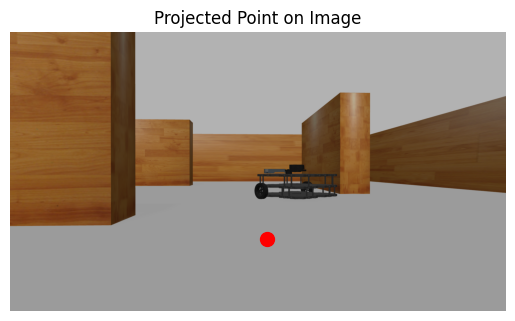

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


observer_pos = np.array([0.96, 0.95, 0])
observer_yaw = 3.04 # in radans
target_pos = np.array([-0.45, 1.15, 0])
observer_height = 0.20  # Observer's camera height from the ground in meters

def transform_to_observer_frame(target_pos, observer_pos, observer_yaw, observer_height):
    relative_pos_2d = target_pos - observer_pos
    relative_pos_3d = np.array([relative_pos_2d[0], relative_pos_2d[1], 0])
    observer_3d_pos = np.array([0, observer_height, 0])  # Observer at origin in 3D
    distance_xy = np.linalg.norm(relative_pos_2d)
    
    relative_pos_3d[2] = distance_xy  # Assume straight line distance is depth in ground plane
    relative_pos_3d[1] = observer_height  # y-component is observer's height
    rotation_matrix = np.array([
        [np.cos(-observer_yaw), -np.sin(-observer_yaw), 0],
        [np.sin(-observer_yaw), np.cos(-observer_yaw), 0],
        [0, 0, 1]  # No rotation needed along z-axis (depth)
    ])
    transformed_pos = rotation_matrix @ relative_pos_3d  
    return transformed_pos

relative_pos = transform_to_observer_frame(target_pos, observer_pos, observer_yaw, 0.2)

def world_to_image_coordinates(X, Y, Z, camera_matrix, rotation_vector, translation_vector):
    rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
    extrinsic_matrix = np.hstack((rotation_matrix, translation_vector))
    projection_matrix = camera_matrix.dot(np.vstack((extrinsic_matrix, [0, 0, 0, 1]))[:3, :])  # Ensure it is a 3x4 matrix
    world_coordinates = np.array([X, Y, Z, 1])
    image_coordinates = projection_matrix.dot(world_coordinates)
    image_coordinates /= image_coordinates[-1]
    return int(image_coordinates[0]), int(image_coordinates[1])

# Camera settings
image_width = 1920
image_height = 1080
horizontal_fov = 1.3439  # radians

# Calculate focal lengths
fx = 0.5 * image_width / np.tan(0.5 * horizontal_fov)
fy = fx  # Assuming square pixels
cx, cy = image_width / 2, image_height / 2

camera_matrix = np.array([
    [fx, 0, cx],
    [0, fy, cy],
    [0, 0, 1]
])

# Optimized extrinsic parameters
optimized_rotation_vector = np.array([0.83606397, -0.48346672, 0.81249374])
optimized_translation_vector = np.array([[-0.76478351], [0.91356075], [-0.05974413]])

# Example usage with optimized extrinsic parameters
u, v = world_to_image_coordinates(relative_pos[0],relative_pos[1],relative_pos[2] , camera_matrix, optimized_rotation_vector, optimized_translation_vector)
print("Image Coordinates u, v:", u, v)


rgb_image_path = "/home/krishna/catkin_ws/src/MEAL/multi_explore/src/RGB/tb3_1_pos_0.96_0.95_yaw_3.04_vs_tb3_0_pos_-0.45_1.15_yaw_-2.55.png"
depth_image_path = "/home/krishna/catkin_ws/src/MEAL/multi_explore/src/Depth/tb3_1_pos_0.96_0.95_yaw_3.04_vs_tb3_0_pos_-0.45_1.15_yaw_-2.55.png"

rgb_image = cv2.imread(rgb_image_path, cv2.IMREAD_COLOR)
depth_image = cv2.imread(depth_image_path, cv2.IMREAD_UNCHANGED)

if rgb_image is None:
    print("Image not found. Please check the path.")
else:
    rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
    rgb_image = cv2.resize(rgb_image, (1920, 1080))
    plt.imshow(rgb_image)
    plt.scatter([u], [v], c='red', s=100)  # Plot the calculated point
    plt.title('Projected Point on Image')
    plt.axis('off')
    plt.show()

Image Coordinates u, v: 1653 200


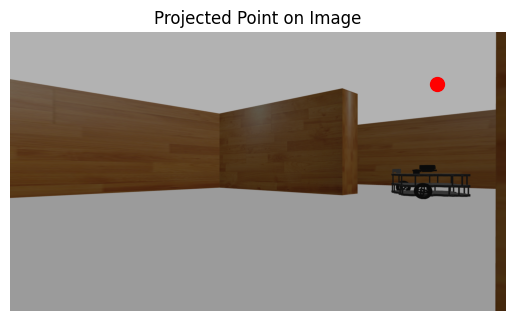

In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d

observer_pos = np.array([-0.15, 0.70, 0])
observer_yaw = 0.88 # in radans
target_pos = np.array([1.41, 1.17, 0])
observer_height = 0.15  # Observer's camera height from the ground in meters

def transform_to_observer_frame(target_pos, observer_pos, observer_yaw, observer_height):
    relative_pos_2d = target_pos - observer_pos
    relative_pos_3d = np.array([relative_pos_2d[0], relative_pos_2d[1], 0])
    observer_3d_pos = np.array([0, observer_height, 0])  # Observer at origin in 3D
    distance_xy = np.linalg.norm(relative_pos_2d)
    
    relative_pos_3d[2] = distance_xy  # Assume straight line distance is depth in ground plane
    relative_pos_3d[1] = observer_height  # y-component is observer's height
    rotation_matrix = np.array([
        [np.cos(-observer_yaw), -np.sin(-observer_yaw), 0],
        [np.sin(-observer_yaw), np.cos(-observer_yaw), 0],
        [0, 0, 1]  # No rotation needed along z-axis (depth)
    ])
    transformed_pos = rotation_matrix @ relative_pos_3d  
    return transformed_pos

relative_pos = transform_to_observer_frame(target_pos, observer_pos, observer_yaw, 0.2)

def world_to_image_coordinates(X, Y, Z, camera_matrix, rotation_vector, translation_vector):
    rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
    extrinsic_matrix = np.hstack((rotation_matrix, translation_vector))
    projection_matrix = camera_matrix.dot(np.vstack((extrinsic_matrix, [0, 0, 0, 1]))[:3, :])  # Ensure it is a 3x4 matrix
    world_coordinates = np.array([X, Y, Z, 1])
    image_coordinates = projection_matrix.dot(world_coordinates)
    image_coordinates /= image_coordinates[-1]
    return int(image_coordinates[0]), int(image_coordinates[1])


# Camera settings
image_width = 1920
image_height = 1080
horizontal_fov = 1.3439  # radians

# Calculate focal lengths
fx = 0.5 * image_width / np.tan(0.5 * horizontal_fov)
fy = fx  # Assuming square pixels
cx, cy = image_width / 2, image_height / 2

camera_matrix = np.array([
    [fx, 0, cx],
    [0, fy, cy],
    [0, 0, 1]
])

# Optimized extrinsic parameters
optimized_rotation_vector = np.array([0.83606397, -0.48346672, 0.81249374])
optimized_translation_vector = np.array([[-0.76478351], [0.91356075], [-0.05974413]])

# Example usage with optimized extrinsic parameters
u, v = world_to_image_coordinates(relative_pos[0],relative_pos[1],relative_pos[2] , camera_matrix, optimized_rotation_vector, optimized_translation_vector)
print("Image Coordinates u, v:", u, v)


rgb_image_path = "/home/krishna/catkin_ws/src/MEAL/multi_explore/src/calibrate/RGB/tb3_1_pos_-0.15_0.70_yaw_0.88_vs_tb3_0_pos_1.41_1.17_yaw_2.66.png"
depth_image_path = "/home/krishna/catkin_ws/src/MEAL/multi_explore/src/calibrate/Depth/tb3_1_pos_-0.15_0.70_yaw_0.88_vs_tb3_0_pos_1.41_1.17_yaw_2.66.png"

rgb_image = cv2.imread(rgb_image_path, cv2.IMREAD_COLOR)
depth_image = cv2.imread(depth_image_path, cv2.IMREAD_UNCHANGED)

if rgb_image is None:
    print("Image not found. Please check the path.")
else:
    rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
    rgb_image = cv2.resize(rgb_image, (1920, 1080))
    plt.imshow(rgb_image)
    plt.scatter([u], [v], c='red', s=100)  # Plot the calculated point
    plt.title('Projected Point on Image')
    plt.axis('off')
    plt.show()

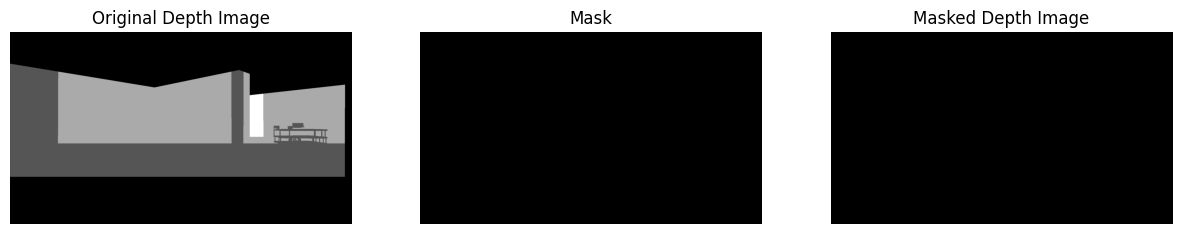

In [72]:
import numpy as np
import matplotlib.pyplot as plt

def create_centered_mask(shape, center, size):
    """Create a square mask of given size centered at center in an array of given shape."""
    mask = np.zeros(shape)
    start_x = max(center[0] - size // 2, 0)
    end_x = min(center[0] + size // 2, shape[0])
    start_y = max(center[1] - size // 2, 0)
    end_y = min(center[1] + size // 2, shape[1])

    mask[start_x:end_x, start_y:end_y] = 1
    return mask

def apply_mask_to_depth_image(depth_image, mask):
    """Apply a mask to the depth image."""
    return np.where(mask == 1, depth_image, 0)

# Create mask and apply to image
mask = create_centered_mask(depth_image.shape, (u, v), 3)
masked_depth_image = apply_mask_to_depth_image(depth_image, mask)

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(depth_image, cmap='gray')
ax[0].set_title('Original Depth Image')
ax[0].axis('off')

ax[1].imshow(mask, cmap='gray')
ax[1].set_title('Mask')
ax[1].axis('off')

ax[2].imshow(masked_depth_image, cmap='gray')
ax[2].set_title('Masked Depth Image')
ax[2].axis('off')

plt.show()

In [4]:
import open3d as o3d

print("Read Redwood dataset")
color_raw = o3d.io.read_image("/home/krishna/catkin_ws/src/MEAL/multi_explore/src/calibrate/RGB/tb3_1_pos_-0.15_0.70_yaw_0.88_vs_tb3_0_pos_1.41_1.17_yaw_2.66.png")
depth_raw = o3d.io.read_image("/home/krishna/catkin_ws/src/MEAL/multi_explore/src/calibrate/Depth/tb3_1_pos_-0.15_0.70_yaw_0.88_vs_tb3_0_pos_1.41_1.17_yaw_2.66.png")
rgbd_image = o3d.geometry.RGBDImage.create_from_nyu_format(color_raw, depth_raw)
print(rgbd_image)

pcd = o3d.geometry.PointCloud.create_from_nyu_format(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd])

: 

In [ ]:
    def is_within_fov(self, observer_name, target_name):
        observer_pos = self.robot_positions[observer_name]
        target_pos = self.robot_positions[target_name]
        observer_yaw = self.robot_orientations[observer_name]
        robot_radius = max(0.281, 0.306, 0.141) / 2
        direction_to_target = target_pos - observer_pos
        distance_to_target = np.linalg.norm(direction_to_target)

        if distance_to_target - robot_radius > self.proximity_threshold:
            return False

        angle_to_target = np.arctan2(direction_to_target[1], direction_to_target[0])
        angle_to_target_normalized = (angle_to_target + np.pi) % (2 * np.pi) - np.pi
        observer_yaw_normalized = (observer_yaw + np.pi) % (2 * np.pi) - np.pi
        angle_difference = (angle_to_target_normalized - observer_yaw_normalized + np.pi) % (2 * np.pi) - np.pi
        angular_size_of_robot = np.arctan(robot_radius / distance_to_target)
        effective_half_fov_rad = np.radians(100 / 2) - angular_size_of_robot
        rospy.loginfo(f"{effective_half_fov_rad}")
        within_fov = abs(angle_difference) - np.radians(40) <= effective_half_fov_rad
        return within_fov

In [ ]:
#!/usr/bin/env python3

import rospy
import numpy as np
from geometry_msgs.msg import PoseWithCovarianceStamped
from std_srvs.srv import Empty
from tf.transformations import euler_from_quaternion
import threading

class ProximitySlamController:
    def __init__(self, robot_namespaces, rtabmap_namespaces, proximity_threshold):
        self.robot_positions = {}
        self.robot_orientations = {}  # Store orientation data separately
        self.proximity_threshold = proximity_threshold
        self.odom_subscribers = []
        self.pause_services = {}
        self.resume_services = {}
        self.slam_paused = {}  # Track whether SLAM is paused for each robot

        for robot_namespace, rtabmap_namespace in zip(robot_namespaces, rtabmap_namespaces):
            odom_topic = f"/{robot_namespace}/amcl_pose"
            self.odom_subscribers.append(rospy.Subscriber(odom_topic, PoseWithCovarianceStamped, self.odom_callback, robot_namespace))

            pause_service_name = f"/{rtabmap_namespace}/pause"
            resume_service_name = f"/{rtabmap_namespace}/resume"
            self.pause_services[robot_namespace] = rospy.ServiceProxy(pause_service_name, Empty)
            self.resume_services[robot_namespace] = rospy.ServiceProxy(resume_service_name, Empty)
            self.slam_paused[robot_namespace] = False

    def odom_callback(self, msg, robot_namespace):
        position = msg.pose.pose.position
        orientation_q = msg.pose.pose.orientation
        self.robot_positions[robot_namespace] = np.array([position.x, position.y])
        _, _, yaw = euler_from_quaternion([orientation_q.x, orientation_q.y, orientation_q.z, orientation_q.w])
        self.robot_orientations[robot_namespace] = yaw
        self.check_proximity_and_control_slam()

    def check_proximity_and_control_slam(self):
        robot_names = list(self.robot_positions.keys())
        if len(robot_names) < 2:
            return

        def handle_robot_pair(robot_name, other_robot_name):
            if self.is_within_fov(robot_name, other_robot_name) and self.calculate_distance(robot_name, other_robot_name) < self.proximity_threshold:
                self.pause_slam(robot_name)
                rospy.loginfo("Paused SLAM")
            else: 
                self.resume_slam(robot_name)

        threads = []
        for i, robot_name in enumerate(robot_names):
            for j, other_robot_name in enumerate(robot_names):
                if i == j:
                    continue
                thread = threading.Thread(target=handle_robot_pair, args=(robot_name, other_robot_name))
                threads.append(thread)
                thread.start()

        for thread in threads:
            thread.join()

    def calculate_distance(self, robot_name, other_robot_name):
        pos1 = self.robot_positions[robot_name]
        pos2 = self.robot_positions[other_robot_name]
        return np.linalg.norm(pos1 - pos2)

    def is_within_fov(self, observer_name, target_name):
        observer_pos = np.array(self.robot_positions[observer_name])
        target_pos = np.array(self.robot_positions[target_name])
        observer_yaw = self.robot_orientations[observer_name]
        robot_radius = max(0.281, 0.306, 0.141) / 2
        direction_to_target = target_pos - observer_pos
        cos_yaw = np.cos(-observer_yaw)
        sin_yaw = np.sin(-observer_yaw)
        rotation_matrix = np.array([[cos_yaw, -sin_yaw],
                                    [sin_yaw, cos_yaw]])
        
        local_direction_to_target = rotation_matrix @ direction_to_target[:2]
        distance_to_target = np.linalg.norm(local_direction_to_target)
        angle_to_target = np.arctan2(local_direction_to_target[1], local_direction_to_target[0])
        angular_size_of_robot = np.arctan(robot_radius / distance_to_target)
        half_fov = 1.3439 / 2  # Horizontal FOV in radians
        dynamic_buffer = min(1 * (1 / distance_to_target), 0.1)  # Cap dynamic buffer to 0.1 radians
        effective_half_fov_rad = half_fov - angular_size_of_robot - dynamic_buffer - 0.2
        rospy.loginfo(f"target_pos:{target_pos}, observer_pos:{observer_pos}")
        return abs(angle_to_target) <= effective_half_fov_rad

    
    def pause_slam(self, robot_namespace):
        try:
            if not self.slam_paused[robot_namespace]:  # Only pause if not already paused
                self.pause_services[robot_namespace]()
                rospy.loginfo(f"SLAM paused for {robot_namespace}")
                self.slam_paused[robot_namespace] = True
        except rospy.ServiceException as e:
            rospy.logwarn(f"Failed to pause SLAM for {robot_namespace}: {e}")

    def resume_slam(self, robot_namespace):
        try:
            if self.slam_paused[robot_namespace]:  # Only resume if it was paused
                self.resume_services[robot_namespace]()
                rospy.loginfo(f"SLAM resumed for {robot_namespace}")
                self.slam_paused[robot_namespace] = False
        except rospy.ServiceException as e:
            rospy.logwarn(f"Failed to resume SLAM for {robot_namespace}: {e}")

if __name__ == "__main__":
    rospy.init_node('proximity_slam_controller')

    robot_namespaces = ['tb3_0', 'tb3_1', 'tb3_2']
    rtabmap_namespaces = ['rtabmap_0', 'rtabmap_1', 'rtabmap_2']
    proximity_threshold = 5

    controller = ProximitySlamController(robot_namespaces, rtabmap_namespaces, proximity_threshold)
    rospy.spin()